<a href="https://colab.research.google.com/github/Raju-24-25/Model-Building-Handsons/blob/main/Forecasting_the_Airline_Passanger_Count_using_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌 1. Problem Statement

Objective:
To build a robust time series forecasting model that predicts the future number of airline passengers using historical monthly passenger data. The goal is to analyze trends, seasonality, and stationarity, apply appropriate transformations, and develop ARIMA and SARIMA models to generate accurate forecasts.

Business Use Case:
Airlines and aviation planners can use such forecasts for:

Capacity planning

Revenue forecasting

Seasonal demand management

Infrastructure optimization

# Step 1 – Dataset Download

In [235]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("chirag19/air-passengers")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'air-passengers' dataset.
Path to dataset files: /kaggle/input/air-passengers


In [236]:
import pandas as pd

df = pd.read_csv(path + "/AirPassengers.csv")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


# Step 2 – Initial Data Inspection

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [238]:
df.isnull().sum()

,0
Month,0
#Passengers,0


In [239]:
df.duplicated().sum()

np.int64(0)

We can clearly see that, the Month Column is present as object data type instead of being date time format. So, there is some data type inconsistency. Let's fix it first.

# Step 3 – Data Type Fixing

In [240]:
df['Month'] = pd.to_datetime(df['Month'])

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [242]:
df1 = df.copy()

# Step 4 – Visualization

In [243]:
import matplotlib.pyplot as plt

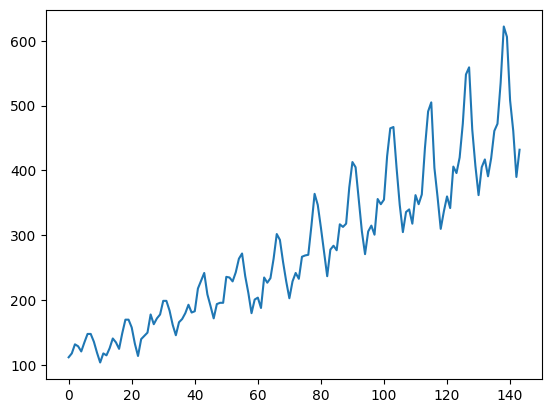

In [244]:
df1['#Passengers'].plot()
plt.show()

# Step 5 – Stationarity Testing (ADF)

In [245]:
from statsmodels.tsa.stattools import adfuller

In [246]:
P_value = adfuller(df1['#Passengers'])[1]
P_value

np.float64(0.991880243437641)

In [247]:
H0 = "The series is non-stationary"
H1 = "The series is stationary"

In [248]:
if P_value > 0.05:
    print(H0)
else:
    print(H1)

The series is non-stationary


# Step 6 – First & Second Order Differencing

In [249]:
df1['#Passengers'] = df1['#Passengers'].diff()

In [250]:
df1.dropna(inplace=True)

In [251]:
df1['#Passengers']

,#Passengers
1,6.0
2,14.0
3,-3.0
4,-8.0
5,14.0
...,...
139,-16.0
140,-98.0
141,-47.0
142,-71.0


In [252]:
P_value = adfuller(df1['#Passengers'])[1]
P_value

np.float64(0.05421329028382478)

In [253]:
if P_value > 0.05:
    print(H0)
else:
    print(H1)

The series is non-stationary


In [254]:
df1['#Passengers'] = df1['#Passengers'].diff()

In [255]:
df1.dropna(inplace=True)

In [256]:
df1['#Passengers']

,#Passengers
2,8.0
3,-17.0
4,-5.0
5,22.0
6,-1.0
...,...
139,-103.0
140,-82.0
141,51.0
142,-24.0


In [257]:
P_value = adfuller(df1['#Passengers'])[1]
P_value

np.float64(2.7328918500142026e-29)

In [258]:
if P_value > 0.05:
    print(H0)
else:
    print(H1)

The series is stationary


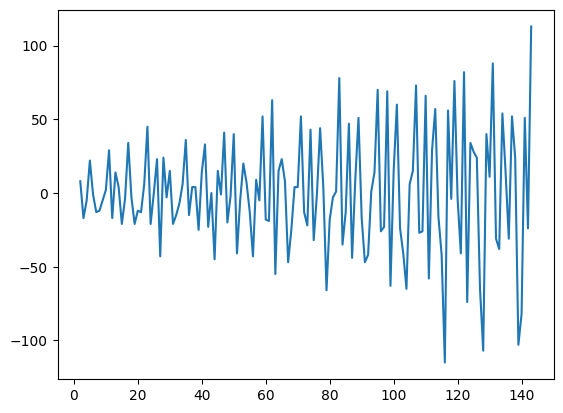

In [259]:
df1['#Passengers'].plot()
plt.show()

# Step 7 – Set Time Index

In [260]:
df = df.set_index('Month')
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


# Step 8 – Seasonal Decomposition

In [261]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [262]:
decompose = seasonal_decompose(df['#Passengers'])

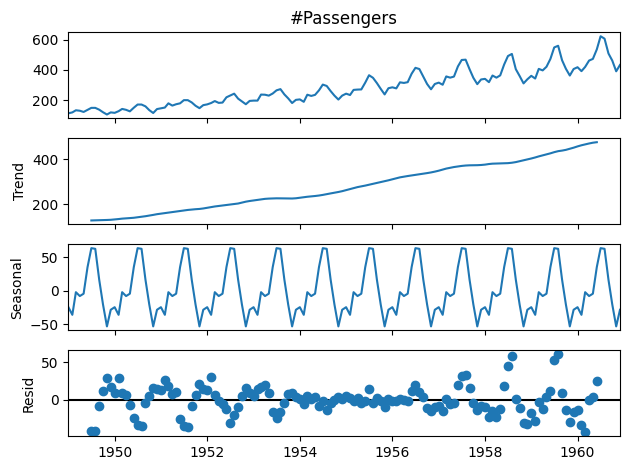

In [263]:
decompose.plot()
plt.show()

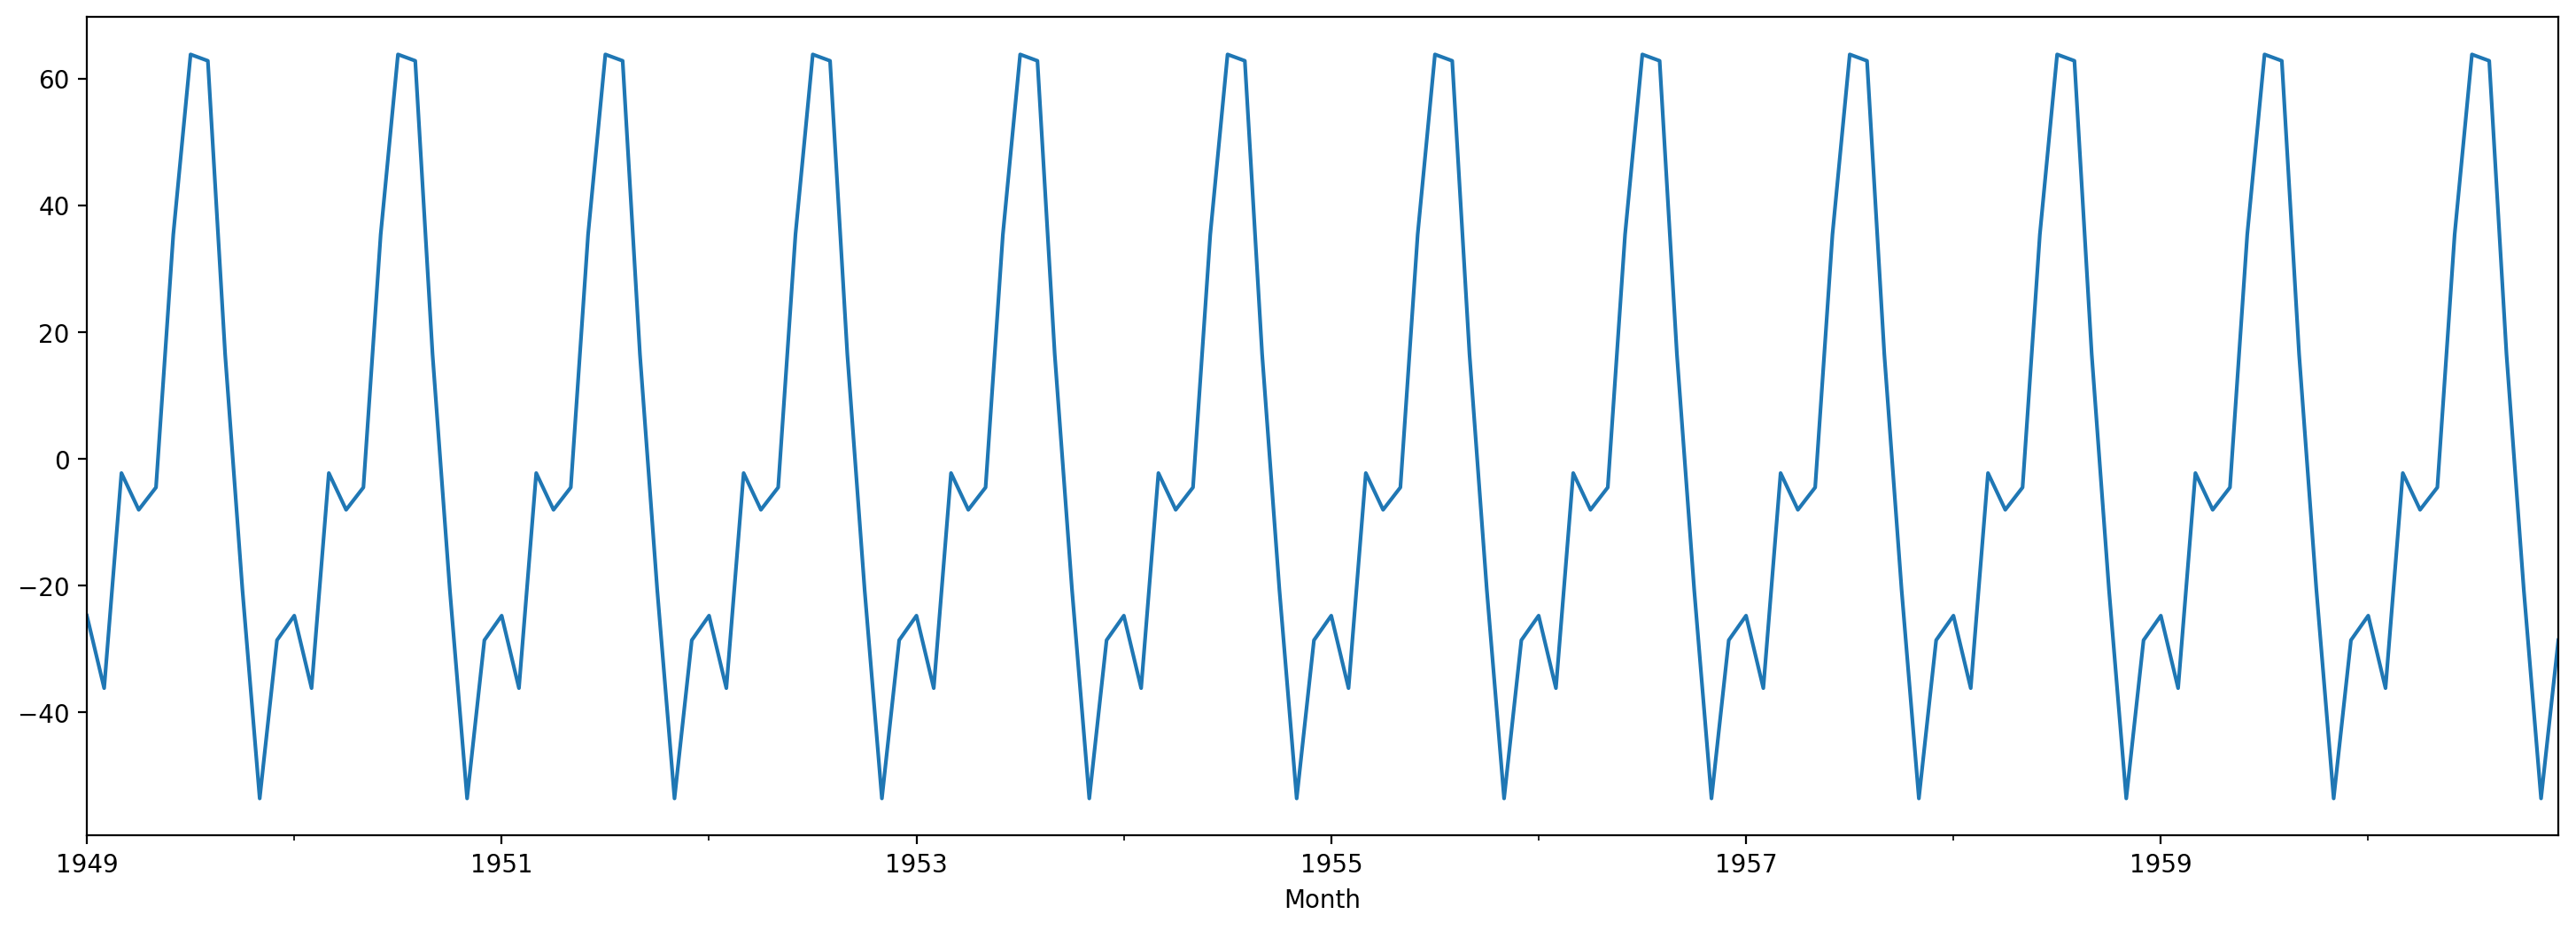

In [264]:
d_seasonal = decompose.seasonal
plt.figure(figsize=(18,6),dpi=200)
d_seasonal.plot()
plt.show()

Till now got the values for s & d i.e 12 & 2, which are much needed to build any of the models i.e ARIMA & SARIMA in the time series data

Now find the other two values that is p & q values. Will get p from pacf and q from acf

# Step 9 – ACF & PACF Analysis

In [265]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

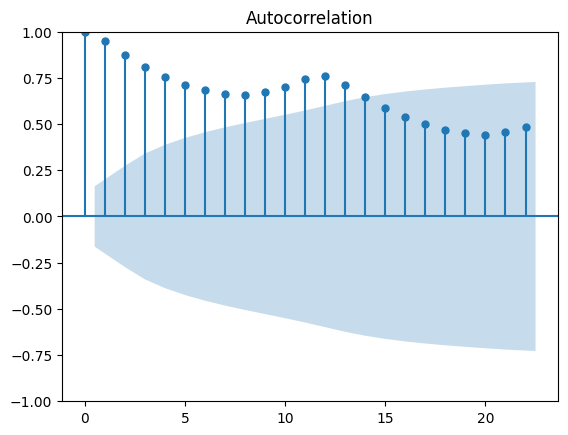

In [266]:
plot_acf(df['#Passengers'])
plt.show()

Lags are decreasing slowly, so it needs differencing

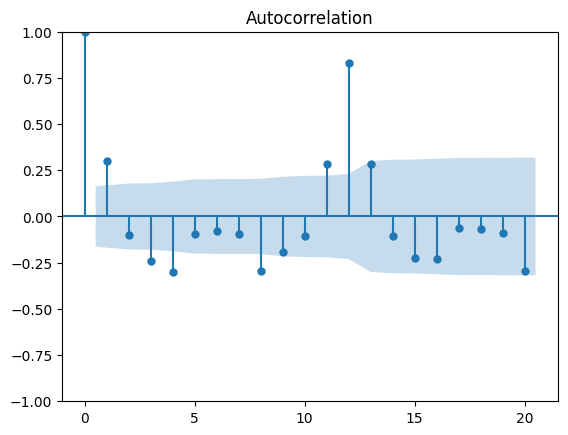

In [267]:
plot_acf(df['#Passengers'].diff().dropna(), lags=20)
plt.show()

So, we can see the value for q is 2

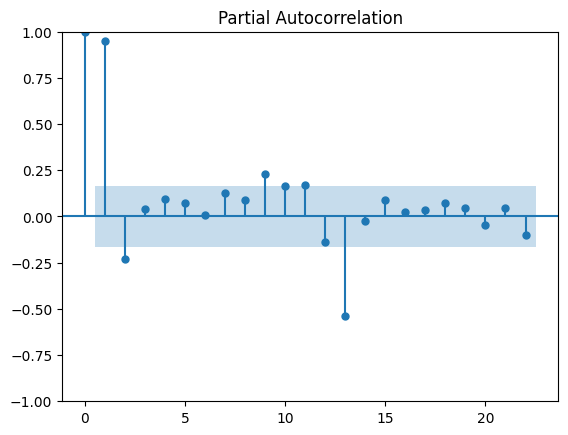

In [268]:
plot_pacf(df['#Passengers'])
plt.show()

Got value of p is 3

# Step 10 – Train-Test Split

In [269]:
split = int(len(df)*0.8)
train = df.iloc[:split]
test = df.iloc[split:]

# Model Building

# Step 11 – ARIMA Model

In [270]:
from statsmodels.tsa.arima.model import ARIMA

In [271]:
arima_model = ARIMA(train, order=(3,2,2))
arima_model = arima_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [272]:
arima_model.predict(start=len(train), end=len(train)+len(test)-1)

,predicted_mean
1958-08-01,504.176234
1958-09-01,500.860588
1958-10-01,504.543361
1958-11-01,506.660745
1958-12-01,511.190588
1959-01-01,513.882878
1959-02-01,517.781444
1959-03-01,520.773789
1959-04-01,524.438016
1959-05-01,527.614501


In [273]:
df['Arima_Prediction'] = arima_model.predict(start=len(train), end=len(train)+len(test)-1)
df

,#Passengers,Arima_Prediction
Month,,
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN
...,...,...
1960-08-01,606,578.438704
1960-09-01,508,581.819707
1960-10-01,461,585.203141


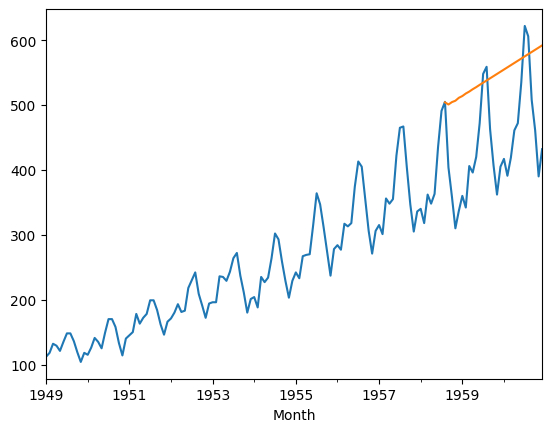

In [274]:
df['#Passengers'].plot()
df['Arima_Prediction'].plot()
plt.show()

# Step 12 – SARIMA Model

In [275]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [276]:
sarima_model = SARIMAX(train, order=(3,2,2), seasonal_order=(1,2,2,12))
sarima_model = sarima_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [277]:
sarima_model.predict(start=len(train),end=len(train)+len(test)-1)

,predicted_mean
1958-08-01,483.227936
1958-09-01,416.364095
1958-10-01,354.739543
1958-11-01,308.702325
1958-12-01,343.020726
1959-01-01,348.708386
1959-02-01,322.721629
1959-03-01,372.622315
1959-04-01,360.690293
1959-05-01,373.878021


In [278]:
df['Sarima_Prediction']=sarima_model.predict(start=len(train),end=len(train)+len(test)-1)
df

,#Passengers,Arima_Prediction,Sarima_Prediction
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
...,...,...,...
1960-08-01,606,578.438704,507.952952
1960-09-01,508,581.819707,426.657451
1960-10-01,461,585.203141,350.701667


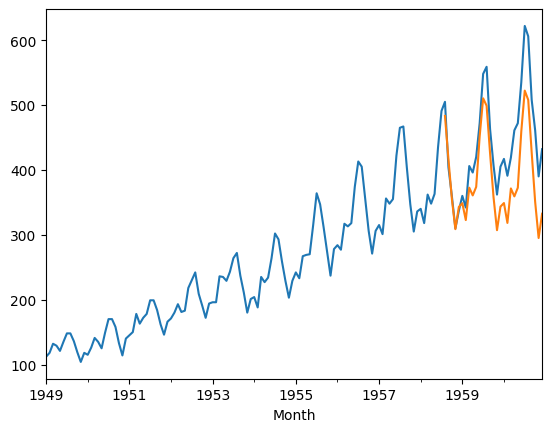

In [279]:
df['#Passengers'].plot()
df['Sarima_Prediction'].plot()
plt.show()

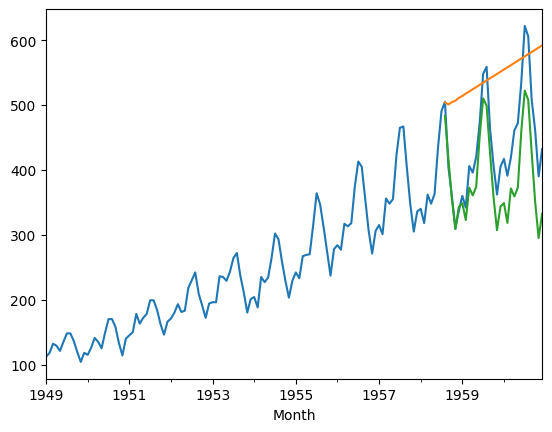

In [285]:
df['#Passengers'].plot()
df['Arima_Prediction'].plot()
df['Sarima_Prediction'].plot()
plt.show()

# Step 13 – Full Data Training & Forecasting

In [280]:
df_final = df['#Passengers']

In [281]:
s_model = SARIMAX(df_final, order=(3,2,2), seasonal_order=(1,2,2,12))
s_model = s_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [282]:
s_forecast = s_model.forecast(steps=48)

In [283]:
s_forecast

,predicted_mean
1961-01-01,450.580741
1961-02-01,417.110184
1961-03-01,461.470391
1961-04-01,486.346372
1961-05-01,505.215186
1961-06-01,576.032927
1961-07-01,668.292490
1961-08-01,658.662954
1961-09-01,547.716289
1961-10-01,490.538614


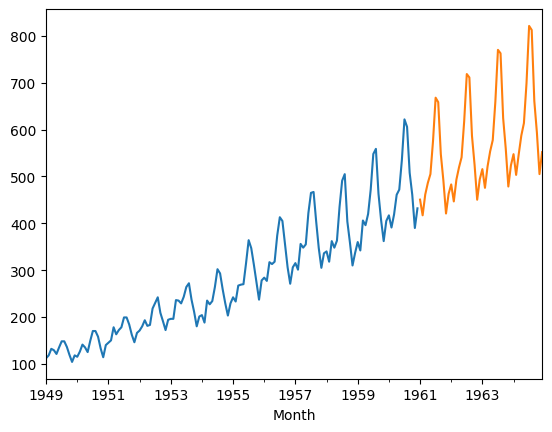

In [284]:
df['#Passengers'].plot()
s_forecast.plot()
plt.show()

# Conclusion

This project successfully demonstrates an end-to-end implementation of time series forecasting for airline passenger demand prediction using historical monthly data. The workflow began with data acquisition from Kaggle, followed by data quality checks, datetime conversion, and visualization to understand overall trends and seasonal patterns. Stationarity was evaluated using the Augmented Dickey-Fuller (ADF) test, and first- and second-order differencing were applied to stabilize the time series.

Seasonal decomposition revealed a strong annual seasonal component with a periodicity of 12 months, which justified the use of seasonal models. Autocorrelation (ACF) and Partial Autocorrelation (PACF) analysis enabled the identification of suitable ARIMA parameters, leading to the implementation of both ARIMA (3,2,2) and SARIMA (3,2,2)(1,2,2,12) models. Visual comparisons showed that the SARIMA model captured seasonal fluctuations more effectively than the standard ARIMA model.

The final model was trained on the complete dataset to forecast passenger demand for the next 48 months, demonstrating the practical applicability of time series forecasting in real-world airline planning scenarios. Although the models provided meaningful trend projections, further improvements such as incorporating quantitative evaluation metrics (RMSE, MAE), dynamic train-test splitting, logarithmic transformations, and automated hyperparameter tuning could enhance forecasting accuracy and robustness.

Overall, this project reflects a strong understanding of time series preprocessing, statistical modeling, and forecasting techniques, and it serves as a solid foundation for advanced predictive analytics and deployment-oriented applications.